Implements "Generating Text with Recurrent Neural Networks" (https://icml.cc/2011/papers/524_icmlpaper.pdf)

<img src="rnn.jpeg" />



DATA
Total characters: 40,888
Unique characters: 100
Training chunk length: 200
Batch size: 64

MODEL
Input size: 100
Hidden size: 256
Factor size: 256
Number of layers: 1
Total parameters: 249,188

TRAIN
Learning rate: 0.001
Number of epochs: 1000
Gradient clipping: 0.25
Weight decay: 0.01
Device: cpu
--------------------------------------------------

epoch: 1/1000, loss: 4.6149, mfu: 15.89%
epoch: 2/1000, loss: 4.6155, mfu: 17.87%
epoch: 3/1000, loss: 4.6125, mfu: 16.56%
epoch: 4/1000, loss: 4.6096, mfu: 16.88%
epoch: 5/1000, loss: 4.6050, mfu: 17.78%
epoch: 6/1000, loss: 4.5979, mfu: 16.04%
epoch: 7/1000, loss: 4.5887, mfu: 16.60%
epoch: 8/1000, loss: 4.5791, mfu: 18.02%
epoch: 9/1000, loss: 4.5668, mfu: 17.15%
epoch: 10/1000, loss: 4.5519, mfu: 17.59%
epoch: 11/1000, loss: 4.5369, mfu: 17.27%
epoch: 12/1000, loss: 4.5208, mfu: 17.73%
epoch: 13/1000, loss: 4.5005, mfu: 16.14%
epoch: 14/1000, loss: 4.4811, mfu: 17.17%
epoch: 15/1000, loss: 4.4548, mfu: 18.22%
epoch: 16/1000, loss: 

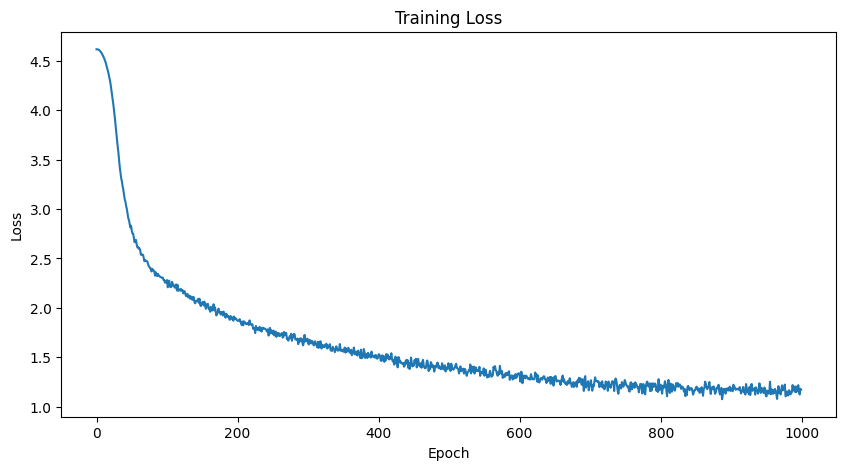


SAMPLE:



/var/folders/lv/fs2j5vr90zz71f7mbvytr3s80000gn/T/ipykernel_16440/2974536355.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mode

First off the rap in the way me hoby's pland open from here in moneys, gin'
I'm from crise in the right Califorie, how tream but to recoh
That's motherfuckers to party owna don't wanna find you brightal, they leam
Suffer
Like gone insan as a ride and my hishin' money is die
Tripped, with me, Ou killingin' for me
And life good to deal motherfuckin' at make, 0cause all you toper when I was shit I slow as a thug I got a kirs
To the scoppin' (Live the life how I'm this is to a 15-shems by me will clock and with me
And you wanmand it
And a pool, but it's time you deated and back to the kight
My motherfucker
We was trive where when you, my little hoes
Hown
Comin' pocket rewn
And a Bearly gettin' and these say the peace
We've when I gift

Soures, and didn't get you kill you gunna start to the streets?
Yound how then it's on the West, it do from a here now?
Thank 'cause it's crash wryin' to kepreciateds
" with shit I don't take through it
And bulla stand mother be these police be lide's little

In [62]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import string
import random
import time
import numpy as np
import matplotlib.pyplot as plt

EPOCHS = 1000
PRINT_EVERY = 1
LEARNING_RATE = 1e-3
PREDICT_LENGTH = 50 
TEMPERATURE = 0.8
CHUNK_LENGTH = 200
CHARACTERS = string.printable
INPUT_PATH = 'data/tupac.txt'
INPUT_SIZE = OUTPUT_SIZE = len(CHARACTERS)
HIDDEN_SIZE = 256
FACTOR_SIZE = 256
NUM_LAYERS = 1
GRAD_CLIP = 0.25
DROPOUT = 0.0
WARMUP_EPOCHS = 100
MIN_LR = 1e-5
BATCH_SIZE = 64 
WEIGHT_DECAY = 0.01


class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        self.beta = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True, unbiased=False)
        return self.gamma * (x - mean) / (var + self.eps).sqrt() + self.beta

class MultiplicativeRNN(nn.Module):
    def __init__(self, input_size, hidden_size, factor_size, output_size, num_layers, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.factor_size = factor_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        init_scale = 0.05
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.encoder_norm = LayerNorm(hidden_size)
        
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'W_fx': nn.Linear(hidden_size, factor_size, bias=False),
                'W_fh': nn.Linear(hidden_size, factor_size, bias=False),
                'W_hf': nn.Linear(factor_size, hidden_size, bias=True),
                'layer_norm': LayerNorm(hidden_size)
            }) for _ in range(num_layers)
        ])
        
        self.decoder = nn.Linear(hidden_size, output_size)
        
        for name, p in self.named_parameters():
            if p.dim() > 1:
                if 'W_fx' in name or 'W_fh' in name:
                    nn.init.orthogonal_(p, gain=init_scale)
                else:
                    nn.init.xavier_normal_(p, gain=init_scale)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        encoded = self.encoder_norm(encoded)
        encoded = nn.functional.dropout(encoded, p=self.dropout, training=self.training)
        
        new_hidden = []
        current_input = encoded
        
        for layer_idx, layer in enumerate(self.layers):
            prev_hidden = hidden[layer_idx]
            
            f_t = layer['W_fx'](current_input) * torch.sigmoid(layer['W_fh'](prev_hidden))
            h_t = torch.tanh(layer['W_hf'](f_t))
            
            h_t = layer['layer_norm'](h_t + current_input)
            h_t = nn.functional.dropout(h_t, p=self.dropout, training=self.training)
            
            new_hidden.append(h_t)
            current_input = h_t
        
        output = self.decoder(current_input)
        hidden = torch.stack(new_hidden)
        
        return output, hidden

    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size))

def get_lr(epoch):
    if epoch < WARMUP_EPOCHS:
        return LEARNING_RATE * (epoch / WARMUP_EPOCHS)
    progress = (epoch - WARMUP_EPOCHS) / (EPOCHS - WARMUP_EPOCHS)
    return MIN_LR + (LEARNING_RATE - MIN_LR) * 0.5 * (1 + np.cos(np.pi * progress))

def estimate_flops(model, sequence_length, batch_size):
    H = HIDDEN_SIZE
    F = FACTOR_SIZE
    V = INPUT_SIZE
    L = sequence_length
    B = batch_size
    
    flops = B * L * (
        2 * H * F +
        2 * H * F +
        F +
        2 * F * H +
        2 * H * V
    )
    return flops

def char_tensor(string, target_length=None):
    tensor = torch.zeros(len(string) if target_length is None else target_length).long()
    for c in range(min(len(string), len(tensor))):
        try:
            tensor[c] = CHARACTERS.index(string[c])
        except ValueError:
            continue
    return Variable(tensor)

def get_batch(data, batch_size):
    inputs = torch.zeros(batch_size, CHUNK_LENGTH).long()
    targets = torch.zeros(batch_size, CHUNK_LENGTH).long()
    
    for b in range(batch_size):
        start_idx = random.randint(0, len(data) - CHUNK_LENGTH - 1)
        chunk = data[start_idx:start_idx + CHUNK_LENGTH + 1]
        inputs[b] = char_tensor(chunk[:-1], CHUNK_LENGTH)
        targets[b] = char_tensor(chunk[1:], CHUNK_LENGTH)
    
    return Variable(inputs), Variable(targets)

def generate(model, prime_str='A', predict_len=100, temperature=0.8):
    hidden = model.init_hidden(batch_size=1)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    for p in range(len(prime_str)):
        _, hidden = model(prime_input[p].unsqueeze(0), hidden)

    inp = prime_input[-1]

    for p in range(predict_len):
        output, hidden = model(inp.unsqueeze(0), hidden)
        output_dist = output.data.view(-1).div(temperature).exp()
        top_idx = torch.multinomial(output_dist, 1)[0]
        predicted_char = CHARACTERS[top_idx]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

def print_model_info(model, data):
    num_params = sum(p.numel() for p in model.parameters())
    print(f"\nDATA")
    print(f"Total characters: {len(data):,}")
    print(f"Unique characters: {len(CHARACTERS)}")
    print(f"Training chunk length: {CHUNK_LENGTH}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"\nMODEL")
    print(f"Input size: {INPUT_SIZE}")
    print(f"Hidden size: {HIDDEN_SIZE}")
    print(f"Factor size: {FACTOR_SIZE}")
    print(f"Number of layers: {NUM_LAYERS}")
    print(f"Total parameters: {num_params:,}")
    print(f"\nTRAIN")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Number of epochs: {EPOCHS}")
    print(f"Gradient clipping: {GRAD_CLIP}")
    print(f"Weight decay: {WEIGHT_DECAY}")
    print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
    print("-" * 50 + "\n")

def train(model, data):
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        betas=(0.9, 0.95)
    )
    criterion = nn.CrossEntropyLoss()
    best_loss = float('inf')
    losses = []
    
    try:
        for epoch in range(EPOCHS):
            model.train()
            start_time = time.time()
            
            current_lr = get_lr(epoch)
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
            
            inp, target = get_batch(data, BATCH_SIZE)
            hidden = model.init_hidden(BATCH_SIZE)
            model.zero_grad()
            loss = 0

            for c in range(CHUNK_LENGTH):
                output, hidden = model(inp[:, c], hidden)
                loss += criterion(output.view(BATCH_SIZE, -1), target[:, c])

            if torch.isnan(loss):
                print(f"NaN loss detected at epoch {epoch+1}. Stopping training.")
                break

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            loss = loss.item() / CHUNK_LENGTH
            losses.append(loss)
            
            if loss < best_loss:
                best_loss = loss
                torch.save(model.state_dict(), 'best_model.pt')
            
            if (epoch + 1) % PRINT_EVERY == 0:
                time_per_epoch = time.time() - start_time
                flops = estimate_flops(model, CHUNK_LENGTH, BATCH_SIZE)
                flops_per_sec = flops / time_per_epoch if time_per_epoch > 0 else 0
                print(f'epoch: {epoch+1}/{EPOCHS}, loss: {loss:.4f}, mfu: {flops_per_sec/1e9:.2f}%')

        plt.figure(figsize=(10, 5))
        plt.plot(losses)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        plt.close()
        
    except KeyboardInterrupt:
        print('Training interrupted')

with open(INPUT_PATH, 'r', encoding='utf-8') as f:
    data = f.read()

model = MultiplicativeRNN(
    INPUT_SIZE,
    HIDDEN_SIZE,
    FACTOR_SIZE,
    OUTPUT_SIZE,
    NUM_LAYERS,
    DROPOUT
)

print_model_info(model, data)
train(model, data)

print("\nSAMPLE:\n")
model.load_state_dict(torch.load('best_model.pt'))
print(generate(model, 'First off ', 1000))

In [65]:
model = MultiplicativeRNN(
        INPUT_SIZE,
        HIDDEN_SIZE,
        FACTOR_SIZE,
        OUTPUT_SIZE,
        NUM_LAYERS,
        DROPOUT
    )
model.load_state_dict(torch.load('best_model.pt'))
print(generate(model, 'First off ', 500))

First off the comin' shake it, and his this in the left and my life as a last the way it was they bustin' in the tarned on with me, I'm tring it's throw the scromptand my motherfucker
Keep me hollin'

The both
And busty, my breathe smics when I get lady
All your drove motherfuckanges, we let up? (Dear chottle shake it is

We ain't drave the life on tell and all to keep it love the hate
They got to make it up

We life on the concrete
Me un, F0cause no women
All eyes on me
And it's that I ain't niggas to de


/var/folders/lv/fs2j5vr90zz71f7mbvytr3s80000gn/T/ipykernel_16440/4252026083.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.